# Get Started With Object Detection Using TensorFlow


### References:

https://www.tensorflow.org/datasets/catalog/overview#all_datasets

https://tfhub.dev/

https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb

http://cocodataset.org/#home


# Create the environment

Import necessary libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

Load pre-trained EfficientDet model, trained on COCO 2017 dataset

In [2]:
url = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'
efficientdet = hub.load(url)

In [3]:
#tf.keras.utils.plot_model(model)
efficientdet

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f70a51ed690>

# Download some dataset for inference

In [4]:
!git clone https://github.com/RajkumarGalaxy/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 160 (delta 43), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (160/160), 12.39 MiB | 15.07 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [5]:
images = []
for i in range(1,11):
    url = './dataset/Images/%03d.jpg'%i
    img = cv2.imread(url)
    # cv2 reads image in BGR format
    # convert BGR into RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # EfficientDet expects 512 by 512
    img = tf.image.resize(img, (512,512))
    # EfficientDet expects uint8
    img = tf.cast(img, tf.uint8)
    # EffiencientDet expects [1,512,512,3]
    img = tf.expand_dims(img, axis=0)
    images.append(img)

In [6]:
images[0].shape

TensorShape([1, 512, 512, 3])

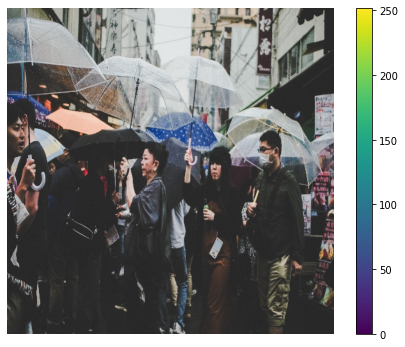

In [7]:
img = images[0].numpy().reshape(512,512,3)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.colorbar()
plt.show()

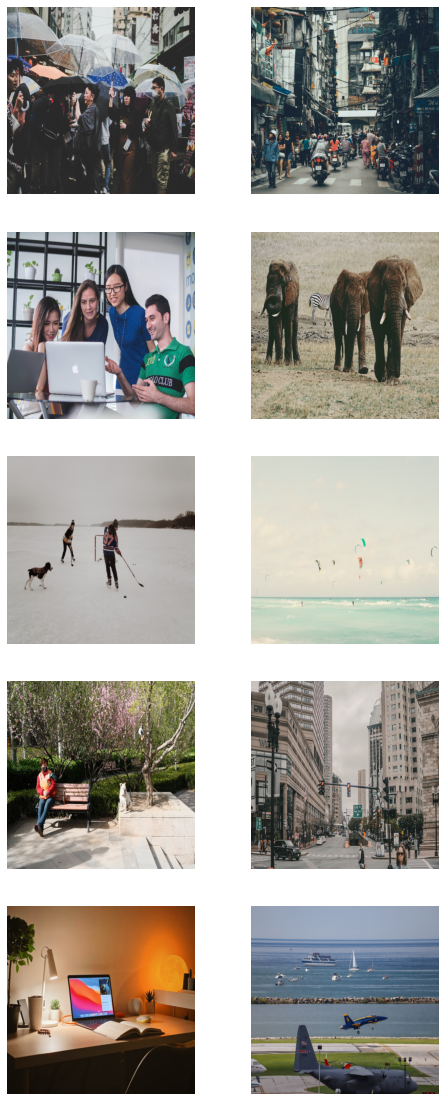

In [8]:
plt.figure(figsize=(8,20))
for i in range(10):
    img = images[i].numpy().reshape(512,512,3)
    plt.subplot(5,2,i+1)
    plt.imshow(img)
    plt.axis('off')
# plt.tight_layout()
plt.show()

# Inference

In [9]:
results = []
for i in range(10):
    res = efficientdet(images[i])
    results.append(res)
    
results[0].keys()

dict_keys(['detection_anchor_indices', 'raw_detection_scores', 'num_detections', 'detection_boxes', 'detection_classes', 'detection_scores', 'detection_multiclass_scores', 'raw_detection_boxes'])

# Visualize results

Clone the TensorFlow models repo and install Object Detection API

In [10]:
!git clone --depth 1 https://github.com/tensorflow/models


Cloning into 'models'...
remote: Enumerating objects: 2648, done.
remote: Counting objects: 100% (2648/2648), done.
remote: Compressing objects: 100% (2193/2193), done.
remote: Total 2648 (delta 670), reused 1286 (delta 422), pack-reused 0
Receiving objects: 100% (2648/2648), 32.61 MiB | 34.22 MiB/s, done.
Resolving deltas: 100% (670/670), done.


In [11]:
%%bash
sudo apt install -y protobuf-compiler
# change directory
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
# install dependencies
python -m pip install .

Processing /kaggle/working/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1649728 sha256=44ac5d4187f782265821031c0d5c900225928bb2e10d5a13bf6f5aea97e30d56
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0xon20x/wheels/d3/e0/37/addaa349be05bc9a8e02e02876c3154afc70272d2a09a30920
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=8f3b2f14779d05317c4e963e0a18b28568658167e613e2b5364c716d0c4d89af
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for crcmod: filename=crcmod-1.7-cp37-cp37m-linux_x86_64.whl size=36500 sha256=a3255d7a01596f0ead0a64cd32f9d0c3da9f7ebe90e421b4dd52496d035641e4
  Stored in directory: /root/.cache/pip/wheels/dc/9a/e9/49e627353476cec8484343c4ab656f1e0d783ee77b9dde2d1f
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78532 sha256=d7c9411628756c309be894cae6778081f3ae6d9ad

bash: line 1: sudo: command not found
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.2.7 requires dill>=0.3.3, but you have dill 0.3.1.1 which is incompatible.
multiprocess 0.70.11.1 requires dill>=0.3.3, but you have dill 0.3.1.1 which is incompatible.
earthengine-api 0.1.261 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
autogluon-core 0.1.0 requires dill==0.3.3, but you have dill 0.3.1.1 which is incompatible.


In [12]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [13]:
label = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category = label_map_util.create_category_index_from_labelmap(label, 
                                                         use_display_name=True)

In [14]:
def display_detections(image, result):
    result = {key:val.numpy() for key,val in result.items()}

    viz_utils.visualize_boxes_and_labels_on_image_array(
      image,
      result['detection_boxes'][0],
      result['detection_classes'][0].astype(int),
      result['detection_scores'][0],
      category,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=None,
      keypoint_scores=None,
      keypoint_edges=None)

    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

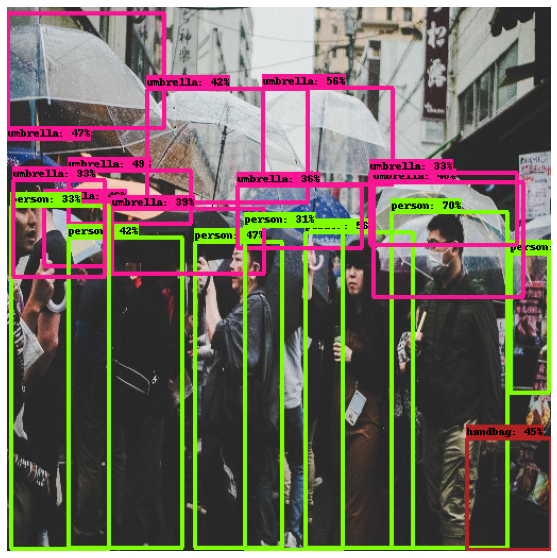

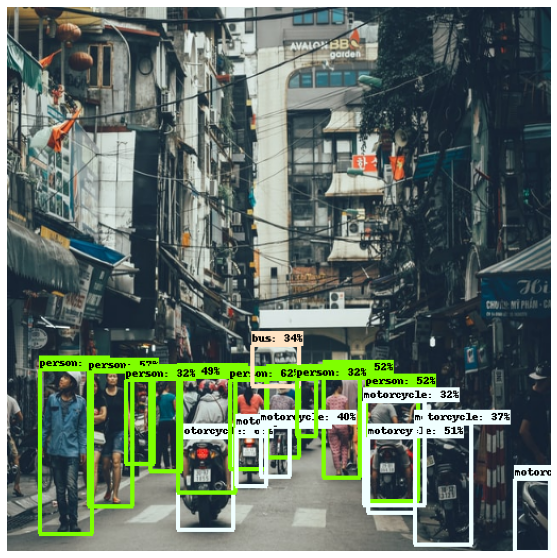

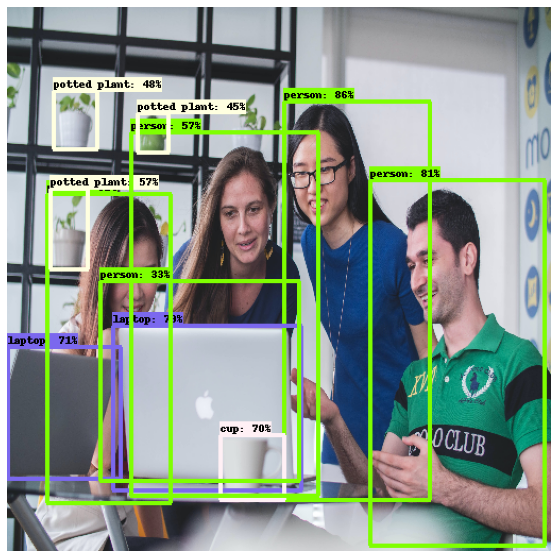

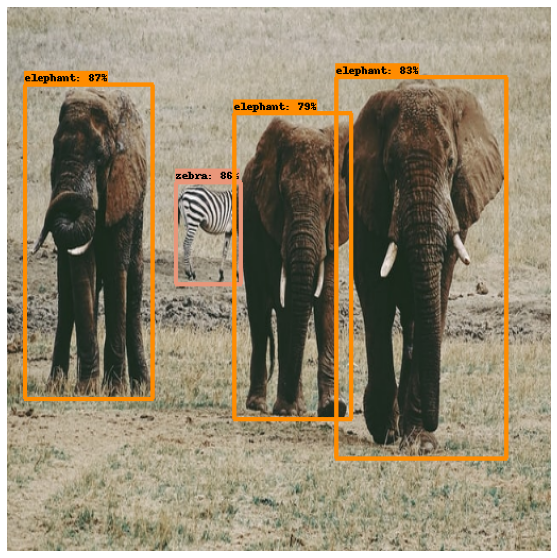

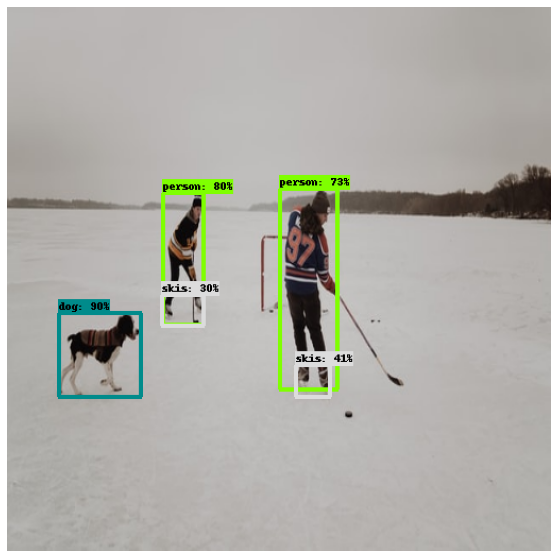

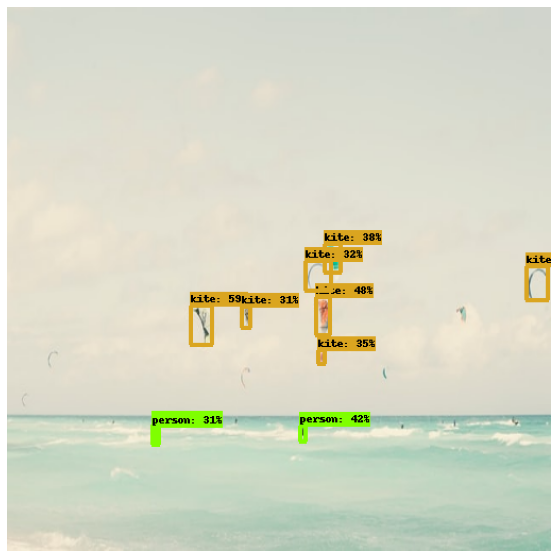

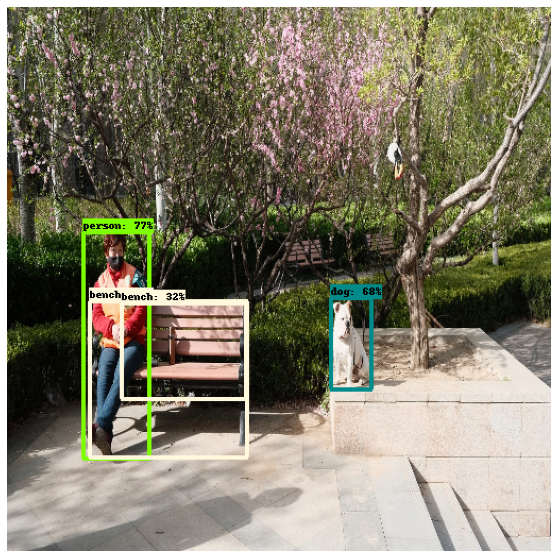

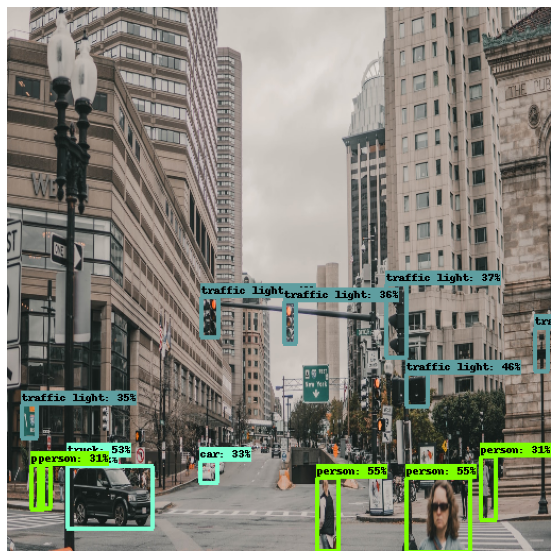

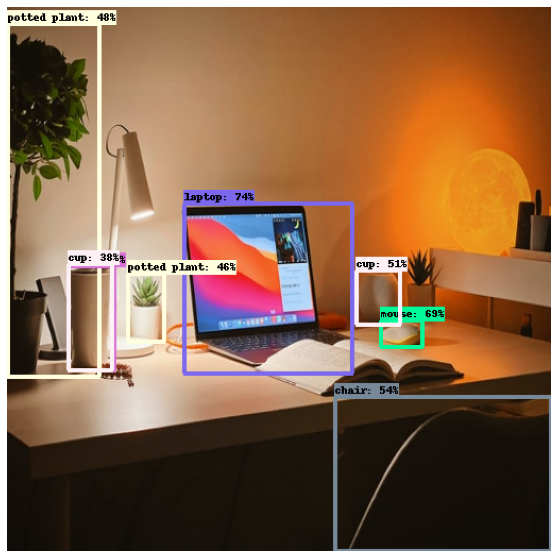

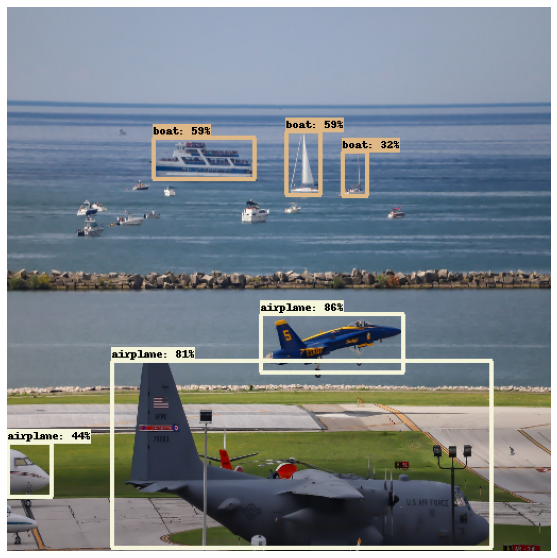

In [15]:
for i in range(10):
    img = images[i].numpy().copy()[0]
    res = results[i]
    display_detections(img, res)